In [2]:

import os
import json
import csv
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import re



task_name = "olympiadbench"
input_dir = "/local/scratch/zli2255/workspace/open-r1/experiments/exp_single_reward/results/single_reward_step_50/olympiadbench/results"
output_csv = f"{input_dir}/result.csv"
task = f"{task_name}|0"
metric = "extractive_match"


# 存储 (文件名, Accuracy)
rows = []

# 递归遍历所有子目录
for root, _, files in os.walk(input_dir):
    for filename in files:
        if filename.endswith(".json"):
            filepath = os.path.join(root, filename)
            try:
                with open(filepath, "r", encoding="utf-8") as f:
                    data = json.load(f)

                acc = data["results"][f"custom|{task}"][f"{metric}"]
                
                # 相对路径作为标识
                relative_path = os.path.relpath(filepath, input_dir)
                rows.append((relative_path, acc))

            except Exception as e:
                print(f"❌ 跳过 {filepath}: {e}")

# 写入 CSV 文件
with open(output_csv, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["Model", "Accuracy"])
    writer.writerows(rows)

print(f"✅ 已写入 {output_csv}，共 {len(rows)} 条记录")


# 读取 CSV
df = pd.read_csv(output_csv)
averaged_results_csv = f"{Path(output_csv).parent}/averaged_results.csv"

# 去除可能的空格（特别是 Method 或 Model 列）
df["Model"] = df["Model"].apply(lambda x: str(Path(x).parent))
if "Method" in df.columns:
    df["Method"] = df["Method"].str.strip()

    # 按 Method 和 Model 分组，并求 Accuracy 平均值
    df_avg = df.groupby(["Method", "Model"], as_index=False)["Accuracy"].mean()
else:
    df_avg = df.groupby(["Model"], as_index=False)["Accuracy"].mean()

# 保存为新文件
df_avg.to_csv(averaged_results_csv, index=False)

print(f"✅ 已保存平均结果到 {averaged_results_csv}")


def parse_result_csv(csv_path):
    """
    解析LoRA实验结果csv，提取Method、Ratio、Step，并保留Accuracy
    
    参数:
        csv_path (str): 输入CSV文件路径，要求包含列 ["Model", "Accuracy"]
        output_path (str): 可选，保存解析后的CSV文件路径
    
    返回:
        pd.DataFrame: 带有新列 [Model, Accuracy, Method, Ratio, Step] 的结果
    """
    df = pd.read_csv(csv_path)
    
    methods, ratios, steps = [], [], []

    for model in df["Model"]:
        # Method
        if "mix_reward" in model:
            method = "mix_reward"
        elif "merge_policy" in model:
            method = "merge_policy"
        else:
            method = "individual"
        methods.append(method)

        # Ratio
        match_ratio = re.search(r"_(\d{3})(?=_checkpoint)", model)
        ratio = match_ratio.group(1) if match_ratio else -1
        ratios.append(ratio)

        # Step
        match_step = re.search(r"checkpoint-(\d+)", model)
        step = int(match_step.group(1)) if match_step else -1
        steps.append(step)

    df["Method"] = methods
    df["Ratio"] = ratios
    df["Step"] = steps

    return df


✅ 已写入 /local/scratch/zli2255/workspace/open-r1/experiments/exp_single_reward/results/single_reward_step_50/olympiadbench/results/result.csv，共 3 条记录
✅ 已保存平均结果到 /local/scratch/zli2255/workspace/open-r1/experiments/exp_single_reward/results/single_reward_step_50/olympiadbench/results/averaged_results.csv


# Step Comparison

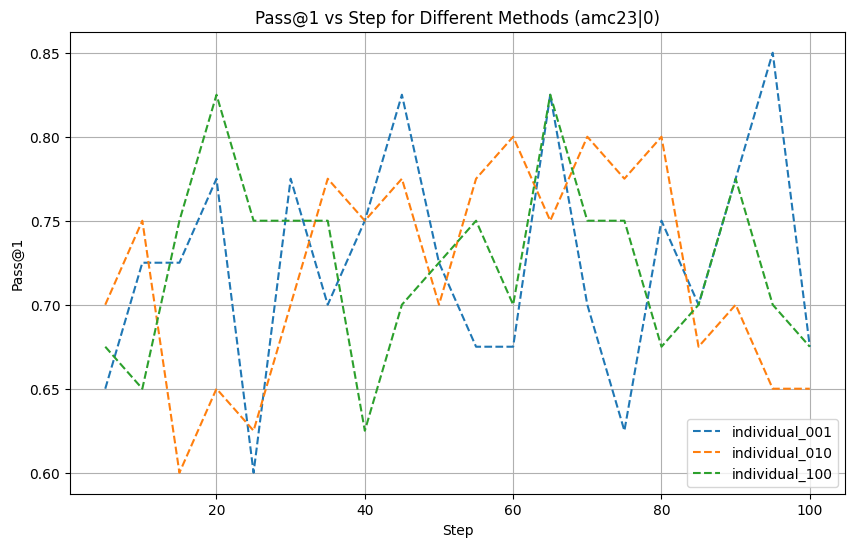

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


# 读入CSV
# df = pd.read_csv(averaged_results_csv)
df = parse_result_csv(averaged_results_csv)

# 合并 Method 和 Ratio 作为标签
df["Method_Ratio"] = df["Method"] + "_" + df["Ratio"].astype(str)

# 绘图
plt.figure(figsize=(10, 6))
for key, grp in df.groupby("Method_Ratio"):
    grp = grp.sort_values("Step")  # 按 Step 排序
    method = grp["Method"].iloc[0]
    linestyle = "--" if method == "individual" else "-"  # individual 用虚线
    plt.plot(grp["Step"], grp["Accuracy"], linestyle=linestyle, label=key)

# # baseline
# baseline = 0.40   # dsqwen1b reevaluated on aime24|0, 0.289 reported in paper
# baseline = 0.533 # dsqwen7b reevaluated on aime24|0, 0.567 reported in paper
# baseline = 0.65 # dsqwen1b amc23|0
# baseline = 0.925 # dsqwen7b amc23|0
# plt.axhline(
#     y=baseline, color="purple", linestyle=":", linewidth=1.5, label=f"Base Model"
# )

plt.xlabel("Step")
plt.ylabel("Pass@1")
plt.title(f"Pass@1 vs Step for Different Methods ({task_name}|0)")
plt.legend()
plt.grid(True)
plt.savefig(f"{input_dir}/step_comparison.png", dpi=300)
plt.show()

# Comparasion

In [ ]:
import matplotlib.pyplot as plt
import csv
from pathlib import Path

# averaged_results_csv = "results/exp5/averaged_results.csv"

# CSV 路径
models = []
accuracies = []

# 读取 CSV
with open(averaged_results_csv, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        model = row["Model"]
        acc = float(row["Accuracy"])
        models.append(model)
        accuracies.append(acc)

# 画柱状图
plt.figure(figsize=(len(models)*2, 10))
bars = plt.bar(models, accuracies, color='skyblue')

plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=45, ha='right')
plt.ylim(min(accuracies) * 0.98, max(accuracies) * 1.02)
plt.grid(axis='y')

# 添加数值标签
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.3f}",
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()

# 保存图像
output_path = f"{input_dir}/comparison.png"
plt.savefig(output_path, dpi=300)
plt.show()


# Mix Reward V.S. Merge Policy

In [ ]:
# 读取 CSV
df = parse_result_csv(averaged_results_csv)

# 确保数据类型正确
df["Ratio"] = df["Ratio"].astype(str)

# 按 Method 分类
methods = df["Method"].unique()

# 设置颜色和样式（可选）
colors = {
    "Mix_Reward": "blue",
    "Merge_Policy": "orange"
}

# 开始画图
plt.figure(figsize=(10, 8))

# for method in methods:
#     subset = df[df["Method"] == method]
    
#     # 按 Ratio 排序以避免折线乱跳
#     subset = subset.sort_values("Ratio")
    
#     plt.plot(
#         subset["Ratio"],
#         subset["Accuracy"],
#         label=method,
#         marker="o",
#         color=colors.get(method, None)
#     )
for method in methods:
    subset = df[df["Method"] == method].copy()  # 加 .copy() 以避免 SettingWithCopyWarning

    # 将 Ratio 转换成数字和
    subset["ScoreSum"] = subset["Ratio"].apply(lambda x: sum(int(d) for d in str(x)))

    # 按 ScoreSum 再按 Ratio 排序，避免线乱跳
    subset = subset.sort_values(by=["ScoreSum", "Ratio"])

    plt.plot(
        subset["Ratio"],
        subset["Accuracy"],
        label=method,
        marker="o",
        color=colors.get(method, None)
    )

# 美化图像
plt.xlabel("Reward Ratio - Accuracy:Format:Length")
plt.ylabel("Accuracy")
plt.title(f"Method Comparison on {task_name}|0shot")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

# 保存或展示
plt.savefig(f"{input_dir}/comparison.png", dpi=300)
plt.show()


# Load five benchmark result

In [5]:
import os
import json
import pandas as pd
import re

# 配置
ROOT_DIR = "/local/scratch/zli2255/workspace/open-r1/experiments/exp_single_reward/results/merge_policy_v2_step_50"  # 起始搜索路径
TASKS = ["aime24", "math_500", "amc23", "minerva", "olympiadbench"]  # 你关心的任务
METRIC = "extractive_match"  # 要取的指标 key

records = {}


for task in TASKS:
    task_dir = os.path.join(ROOT_DIR, task, "results")
    if not os.path.isdir(task_dir):
        continue

    for model_dir in os.listdir(task_dir):
        model_path = os.path.join(task_dir, model_dir)
        if not os.path.isdir(model_path):
            continue

        for fname in os.listdir(model_path):
            if not fname.endswith(".json"):
                continue

            fpath = os.path.join(model_path, fname)
            with open(fpath, "r") as f:
                data = json.load(f)

            try:
                value = data["results"][f"custom|{task}|0"][METRIC]
            except KeyError:
                print(f"⚠️ 跳过 {fpath}, 没有 {task}/{METRIC}")
                continue

            # 用正则提取 model 名称，例如 merge_policy_v2_201
            m = re.search(r"(merge_policy_v\d+_\d+)", model_dir)
            if m:
                model = m.group(1)
            else:
                model = model_dir  # fallback

            if model not in records:
                records[model] = {}
            records[model][task] = value

# 转换为 DataFrame
rows = []
for model, vals in records.items():
    row = {"model": model}
    for task in TASKS:
        row[task] = vals.get(task, None)
    # 平均值
    scores = [row[t] for t in TASKS if row[t] is not None]
    row["avg"] = sum(scores) / len(scores) if scores else None
    rows.append(row)

df = pd.DataFrame(rows)
csv_path = os.path.join(ROOT_DIR, "results_summary.csv")
df.to_csv(csv_path, index=False)

print(f"✅ 已保存 {csv_path}")


✅ 已保存 /local/scratch/zli2255/workspace/open-r1/experiments/exp_single_reward/results/merge_policy_v2_step_50/results_summary.csv
